In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
import numpy as np
import pandas as pd
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
%matplotlib inline

C:\Users\dansc\miniconda3\envs\pytorchenv\lib\site-packages\sklearn\utils\validation.py:37: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  LARGE_SPARSE_SUPPORTED = LooseVersion(scipy_version) >= '0.14.0'


In [2]:
# MNIST IMAGE --> TENSOR
transform = transforms.ToTensor()

In [3]:
# data to load
train_data = datasets.MNIST(root='../../Data', train = True, download= True, transform=transform)
test_data = datasets.MNIST(root='../../Data', train = False, download= True, transform=transform)

In [4]:
train_data

Dataset MNIST
    Number of datapoints: 60000
    Root location: ../../Data
    Split: Train
    StandardTransform
Transform: ToTensor()

In [5]:
image, label = train_data[0]

In [6]:
image.shape

torch.Size([1, 28, 28])

In [7]:
label

5

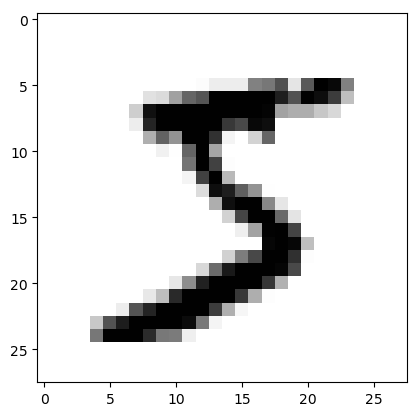

In [8]:
plt.imshow(image.reshape(28,28), cmap='gist_yarg') # viridis is default

In [9]:
torch.manual_seed(101)
train_loader = DataLoader(train_data, batch_size=100, shuffle = True)
test_loader = DataLoader(test_data, batch_size=500, shuffle = False)

In [10]:
from torchvision.utils import make_grid
np.set_printoptions(formatter=dict(int = lambda x: f'{x:4}'))

In [11]:
for images, labels in train_loader:
    break

In [12]:
images

tensor([[[[0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          ...,
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.]]],


        [[[0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          ...,
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.]]],


        [[[0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          ...,
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.]]],


        ...,


        [[[0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          ...,
          [0., 0., 0.,  ..., 0.

In [13]:
images.shape
# 100 images, 1 channel (grey), width, height

torch.Size([100, 1, 28, 28])

In [14]:
labels.shape # 100  of them 

torch.Size([100])

Labels:  [   0    5    7    8    6    7    9    7    1    3    8    4]


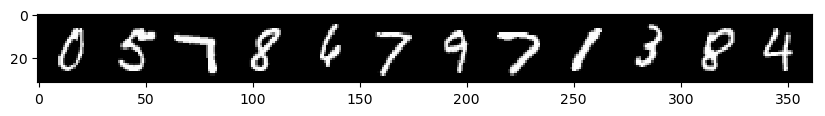

In [15]:
# print first 12 labels
print('Labels: ', labels[:12].numpy())

# print first 12 images
im = make_grid(images[:12], nrow = 12)
plt.figure(figsize=(10,4))

# transpose images from CWH to WHC
plt.imshow(np.transpose(im.numpy(),(1,2,0)))

In [16]:
class MultilayerPerceptrion(nn.Module):
    def __init__(self,in_sz=784, out_sz = 10, layers = [120,84]):
    
        super().__init__()
        
        self.fc1 = nn.Linear(in_sz, layers[0])
        self.fc2 = nn.Linear(layers[0], layers[1])
        self.fc3 = nn.Linear(layers[1], out_sz)
        
    def forward(self, X):
        X = F.relu(self.fc1(X))
        X = F.relu(self.fc2(X))
        X = self.fc3(X)
        
        return F.log_softmax(X, dim = 1) # MULTI CLASS CLASSIFICATION

In [17]:
torch.manual_seed(101)
model = MultilayerPerceptrion()
model

MultilayerPerceptrion(
  (fc1): Linear(in_features=784, out_features=120, bias=True)
  (fc2): Linear(in_features=120, out_features=84, bias=True)
  (fc3): Linear(in_features=84, out_features=10, bias=True)
)

In [18]:
# ANN ---> CNN
for param in model.parameters():
    print(param.numel())
print(f'105,214 total layers!')

94080
120
10080
84
840
10
105,214 total layers!


In [19]:
criterion =  nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr = .001)

In [20]:
# need to flatten.
# should be [100,784] (28 * 28 = 784)
images.shape 

torch.Size([100, 1, 28, 28])

In [21]:
images.view(100, -1).shape # grab 100 the rest are combined

torch.Size([100, 784])

In [22]:
import time
start_time = time.time()

epochs = 10
train_losses = []
test_losses = []
train_correct = []
test_correct = []

for i in range(epochs):
    trn_corr = 0
    tst_corr = 0
    
    # Run the training batches
    for b, (X_train, y_train) in enumerate(train_loader):
        b+=1
        
        # Apply the model
        y_pred = model(X_train.view(100, -1))  # Here we flatten X_train
        loss = criterion(y_pred, y_train)
 
        # Tally the number of correct predictions
        predicted = torch.max(y_pred.data, 1)[1]
        batch_corr = (predicted == y_train).sum()
        trn_corr += batch_corr
        
        # Update parameters
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        # Print interim results
        if b%200 == 0:
            print(f'epoch: {i:2}  batch: {b:4} [{100*b:6}/60000]  loss: {loss.item():10.8f}  \
accuracy: {trn_corr.item()*100/(100*b):7.3f}%')
    
    # Update train loss & accuracy for the epoch
    train_losses.append(loss)
    train_correct.append(trn_corr)
        
    # Run the testing batches
    with torch.no_grad():
        for b, (X_test, y_test) in enumerate(test_loader):

            # Apply the model
            y_val = model(X_test.view(500, -1))  # Here we flatten X_test

            # Tally the number of correct predictions
            predicted = torch.max(y_val.data, 1)[1] 
            tst_corr += (predicted == y_test).sum()
    
    # Update test loss & accuracy for the epoch
    loss = criterion(y_val, y_test)
    test_losses.append(loss)
    test_correct.append(tst_corr)
        
print(f'\nDuration: {time.time() - start_time:.0f} seconds') # print the time elapsed            

epoch:  0  batch:  200 [ 20000/60000]  loss: 0.27582583  accuracy:  83.090%
epoch:  0  batch:  400 [ 40000/60000]  loss: 0.21671551  accuracy:  87.373%
epoch:  0  batch:  600 [ 60000/60000]  loss: 0.21406025  accuracy:  89.393%
epoch:  1  batch:  200 [ 20000/60000]  loss: 0.13820954  accuracy:  94.705%
epoch:  1  batch:  400 [ 40000/60000]  loss: 0.12170443  accuracy:  95.195%
epoch:  1  batch:  600 [ 60000/60000]  loss: 0.11725786  accuracy:  95.435%
epoch:  2  batch:  200 [ 20000/60000]  loss: 0.12593085  accuracy:  96.540%
epoch:  2  batch:  400 [ 40000/60000]  loss: 0.08889172  accuracy:  96.660%
epoch:  2  batch:  600 [ 60000/60000]  loss: 0.09162416  accuracy:  96.765%
epoch:  3  batch:  200 [ 20000/60000]  loss: 0.04546329  accuracy:  97.550%
epoch:  3  batch:  400 [ 40000/60000]  loss: 0.08072864  accuracy:  97.585%
epoch:  3  batch:  600 [ 60000/60000]  loss: 0.04306455  accuracy:  97.592%
epoch:  4  batch:  200 [ 20000/60000]  loss: 0.15830934  accuracy:  97.910%
epoch:  4  b

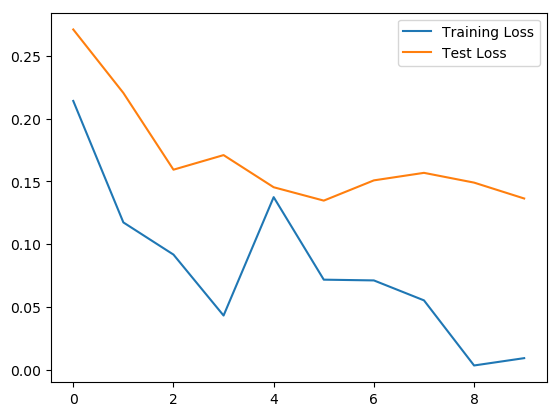

In [25]:
plt.plot(train_losses, label = 'Training Loss')
plt.plot(test_losses, label = 'Test Loss')
plt.legend()
plt.show();

In [35]:
train_acc = [t/600 for t in train_correct]

RuntimeError: Integer division of tensors using div or / is no longer supported, and in a future release div will perform true division as in Python 3. Use true_divide or floor_divide (// in Python) instead.

In [42]:
train_acc = [torch.true_divide(t, 600) for t in train_correct]

In [48]:
test_acc = [torch.true_divide(t, 100) for t in test_correct]

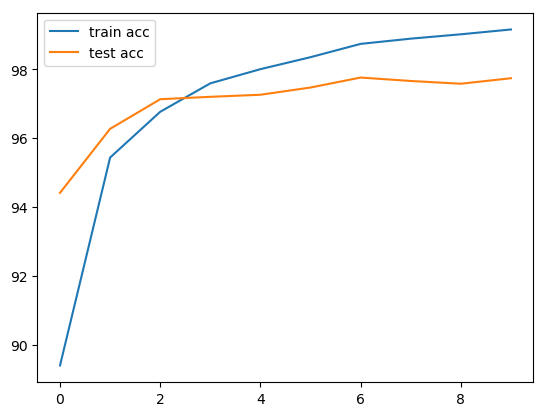

In [49]:
plt.plot(train_acc, label = 'train acc')
plt.plot(test_acc, label = 'test acc')
plt.legend()
plt.show();

In [51]:
# NEW UNSEEN DATA
test_load_all = DataLoader(test_data, batch_size = 10000, shuffle=False)

with torch.no_grad():
    correct = 0
    
    for X_test, y_test in test_load_all:
        y_val = model(X_test.view(len(X_test), -1))
        predicted = torch.max(y_val,1)[1]
        correct += (predicted == y_test).sum()

In [52]:
100 * correct.item()/len(test_data)

97.74

In [53]:
confusion_matrix(predicted.view(-1), y_test.view(-1))

array([[ 966,    0,    1,    0,    2,    2,    6,    0,    4,    0],
       [   0, 1119,    3,    0,    0,    0,    3,    3,    0,    2],
       [   2,    4, 1011,    1,    1,    0,    2,    8,    4,    1],
       [   3,    3,    7,  998,    1,   15,    1,    0,    6,    8],
       [   1,    0,    1,    0,  962,    2,    8,    0,    3,    7],
       [   0,    0,    0,    0,    0,  862,    8,    0,    4,    3],
       [   1,    2,    1,    0,    3,    3,  927,    0,    2,    0],
       [   1,    1,    4,    6,    2,    2,    1, 1014,    6,   11],
       [   4,    6,    4,    2,    2,    4,    2,    2,  943,    5],
       [   2,    0,    0,    3,    9,    2,    0,    1,    2,  972]],
      dtype=int64)